# Imports

In [2]:
from utils.imports import *
from utils.data_loader import download_data, load_data
from utils.models import PretrainedModel, AlexNetVanilla
from utils.utils import preprocess_images, get_current_time

# Initialize data

In [3]:
fnames = ["../kay_labels.npy", "../kay_labels_val.npy", "../kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

if download_data(fnames, urls):
    init_training_inputs, init_test_inputs, training_outputs, test_outputs, roi, roi_names, labels, val_labels = load_data('../kay_images.npz')

In [4]:
# Preprocess the images
training_inputs = preprocess_images(init_training_inputs)
test_inputs = preprocess_images(init_test_inputs)

# Visualization

## Initial insight into data


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [5]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


We have the following data has the following fields:  
- `training_inputs`: stim x i x j array of grayscale stimulus images
- `test_inputs`: stim x i x j array of grayscale stimulus images in the test set  
- `training_outputs`: stim x voxel array of z-scored BOLD response amplitude
- `test_outputs`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [6]:
print("Stimuli shape: ", init_training_inputs.shape)
print("Responses shape: ", training_outputs.shape)

Stimuli shape:  (1750, 128, 128)
Responses shape:  (1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [7]:
roi_count = dict(zip(roi_names, np.bincount(roi)))

print(roi_count)

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}


Each stimulus is a 128 x 128 grayscale array:

C:\Users\simon\AppData\Local\Temp\ipykernel_296\2778045494.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


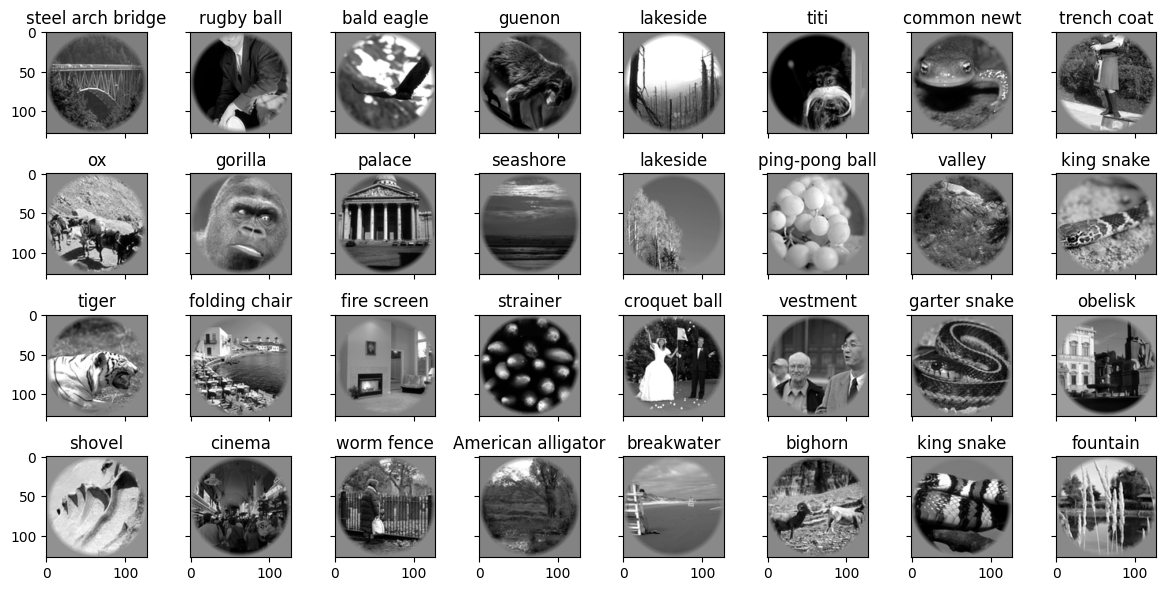

In [8]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, init_test_inputs, val_labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

### Training data:

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\simon\AppData\Local\Temp\ipykernel_296\2771300095.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


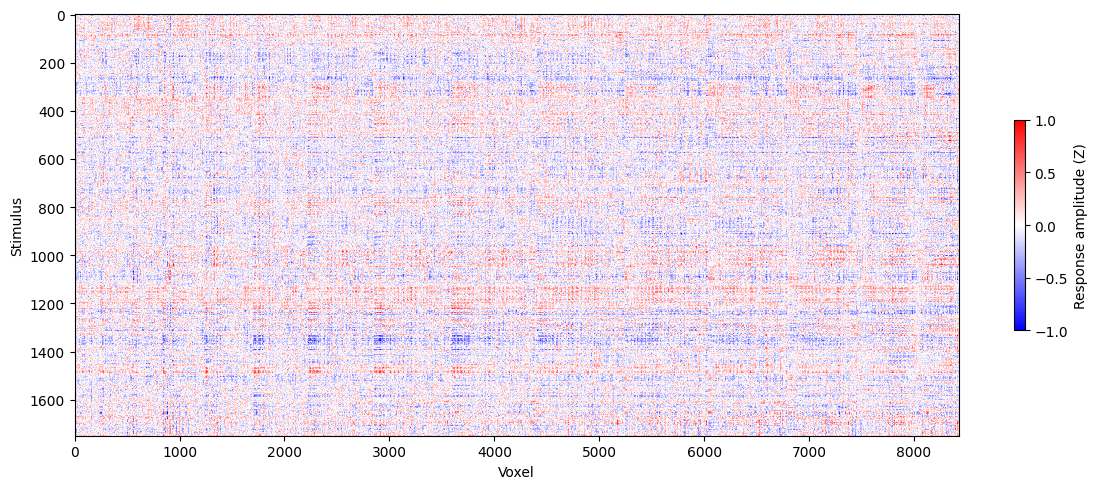

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(training_outputs,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Test data:

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

C:\Users\simon\AppData\Local\Temp\ipykernel_296\1280970321.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


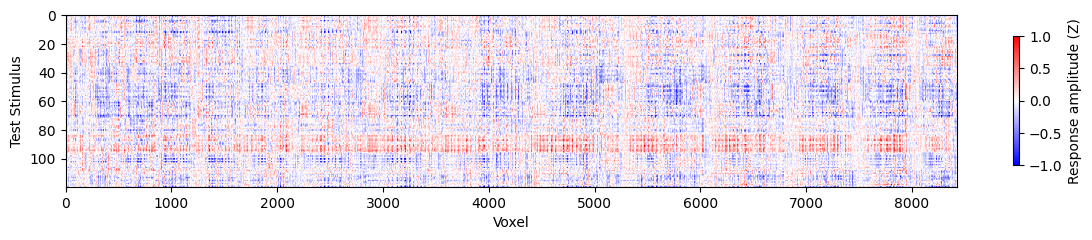

In [10]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(test_outputs,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

## Other visualisations:

### Voxels sorted by ROI

C:\Users\simon\AppData\Local\Temp\ipykernel_296\2765687338.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


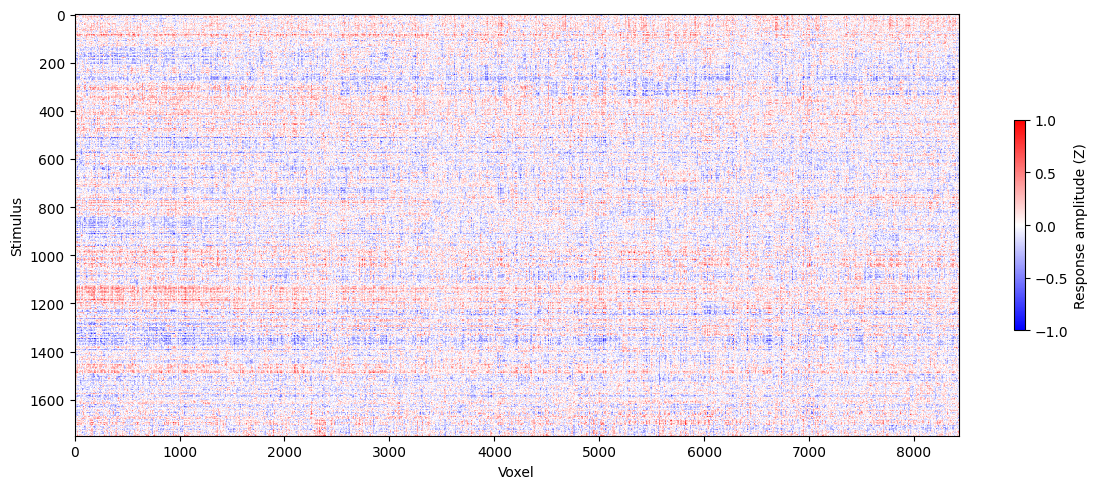

In [11]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(roi)
sorted_roi = roi[roi_order]
sorted_responses = training_outputs[:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Split responses by top-most category

In [12]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [training_outputs[labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

Unique categories: ['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant']
Category animal has shape (589, 8428)
Category artifact has shape (812, 8428)
Category entity has shape (72, 8428)
Category fruit has shape (77, 8428)
Category fungus has shape (5, 8428)
Category geological formation has shape (192, 8428)
Category person has shape (2, 8428)
Category plant has shape (1, 8428)


C:\Users\simon\AppData\Local\Temp\ipykernel_296\1454581728.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


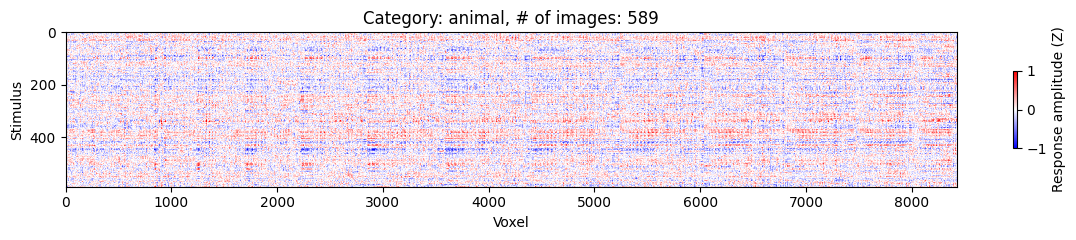

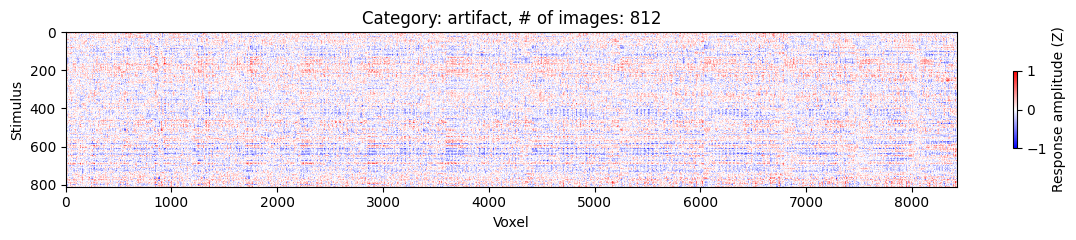

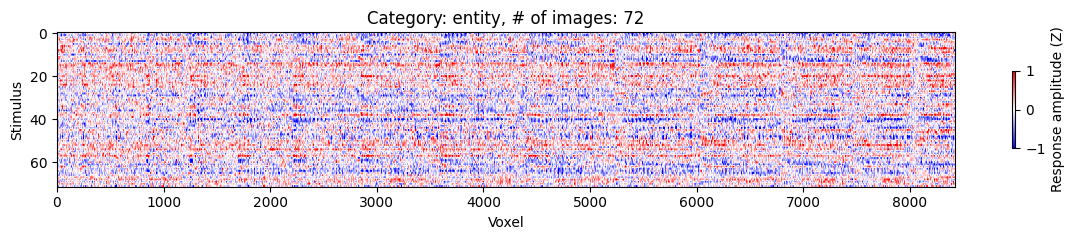

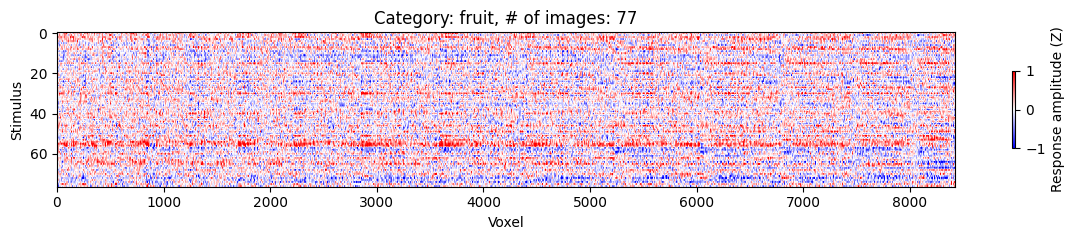

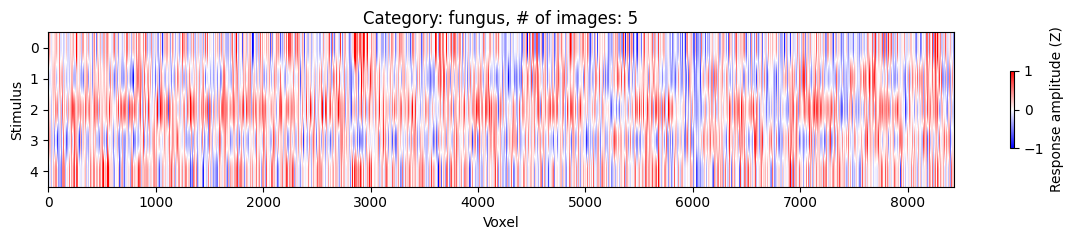

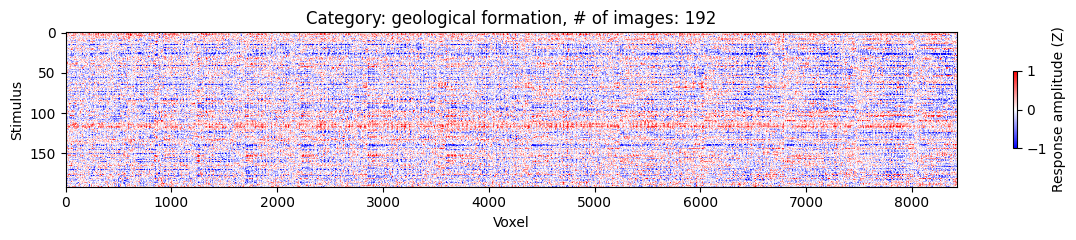

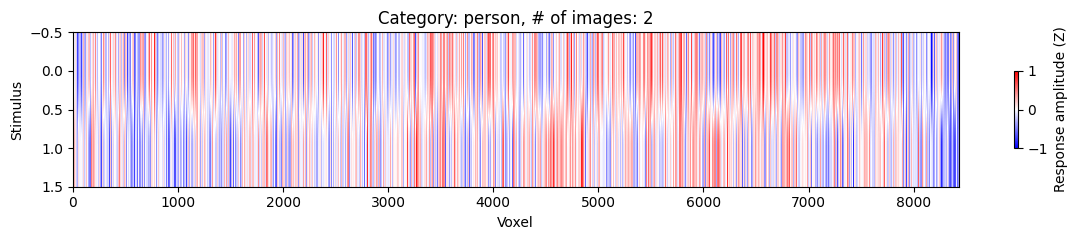

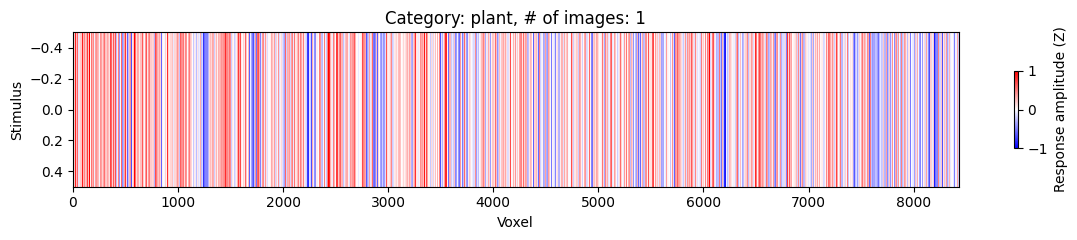

In [13]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

### Visualization of the means for the ROIs, compared across different stimuli of the same category

In [14]:
# Functions for plotting barplots of the different ROI's means for a specific category

def compute_roi_bins(image_index):
    responses = training_outputs
    rois = roi
    roi_names_count = np.bincount(rois)[1:]

    roi_bins = [0, 0, 0, 0, 0, 0, 0]
    # For one image, go through all voxels recorded
    for i in range(len(responses[0])):
        roi_index = rois[i] - 1
        roi_bins[roi_index] += responses[image_index][i]
    for i in range(len(roi_bins)):
        roi_bins[i] /= roi_names_count[i]
    
    return roi_bins

def compute_roi_distributions_from_category(category, category_hierarchy, count):
    index = 0
    graphs_xvalues = []
    graphs_specific_labels = []
    while len(graphs_xvalues) < count:
        #print(labels[category_hierarchy][index], '/', category)
        if labels[category_hierarchy][index] == category: # category hierachy level
            graphs_xvalues.append(compute_roi_bins(index))
            graphs_specific_labels.append(labels[3][index])
        index += 1

    return graphs_xvalues, graphs_specific_labels

def barplot_roi_distribution(category, graph_xvalues, graph_specific_labels, ylim=[-0.4, 0.4], plot_rows=2, plot_cols=3):
    figure, axis = plt.subplots(plot_rows, plot_cols, figsize=(12,8))
    figure.suptitle(category)
    for ax, im, lbl in zip(axis.flat, graph_xvalues, graph_specific_labels):
        ax.set_ylim(ylim)
        ax.bar(range(len(im)), im)
        ax.set_title(lbl)
    figure.tight_layout()
    figure.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_296\4252094417.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


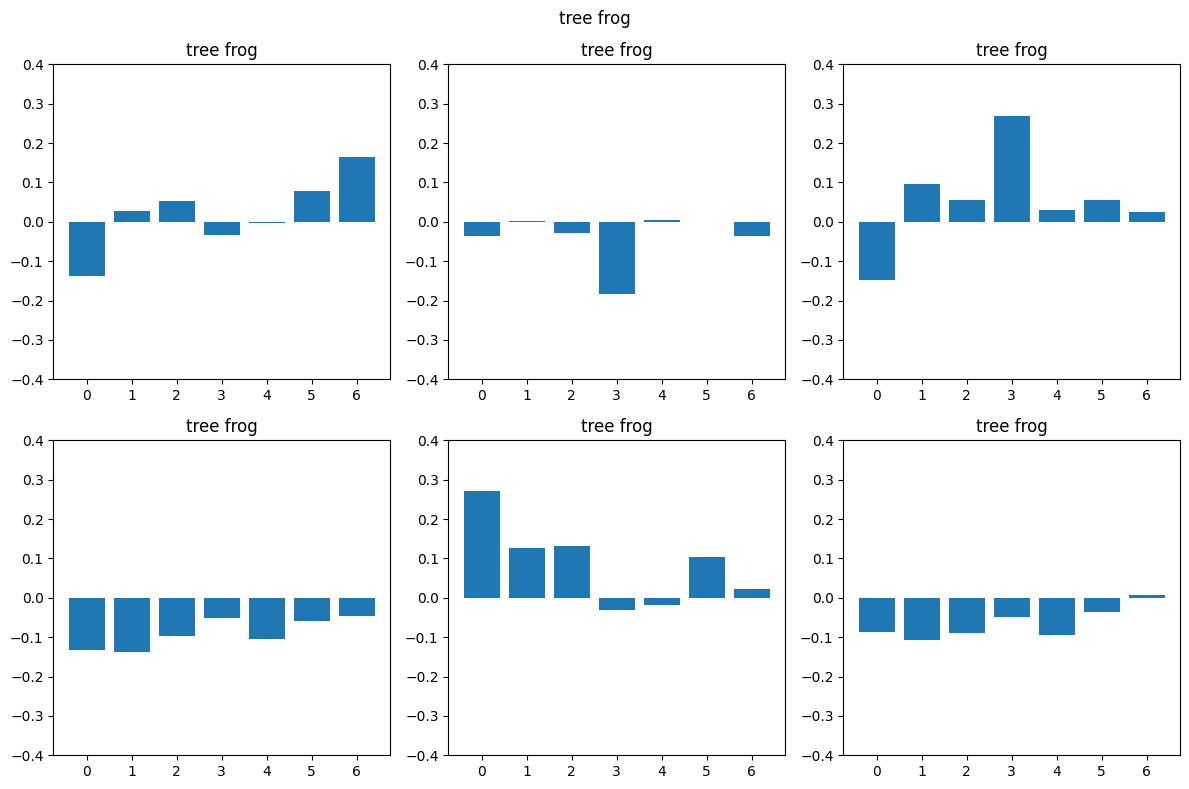

In [15]:
# Plot barplots of ROI distribution for a specified category
# Specify category name, it's hierarchy level, and how many stimili there is
category_name = 'tree frog'
category_hierarchy = 3
count = 6
roi_distributions_values, roi_distibutions_labels = compute_roi_distributions_from_category(category_name, category_hierarchy, count)
barplot_roi_distribution(category_name, roi_distributions_values, roi_distibutions_labels)

C:\Users\simon\AppData\Local\Temp\ipykernel_296\4252094417.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


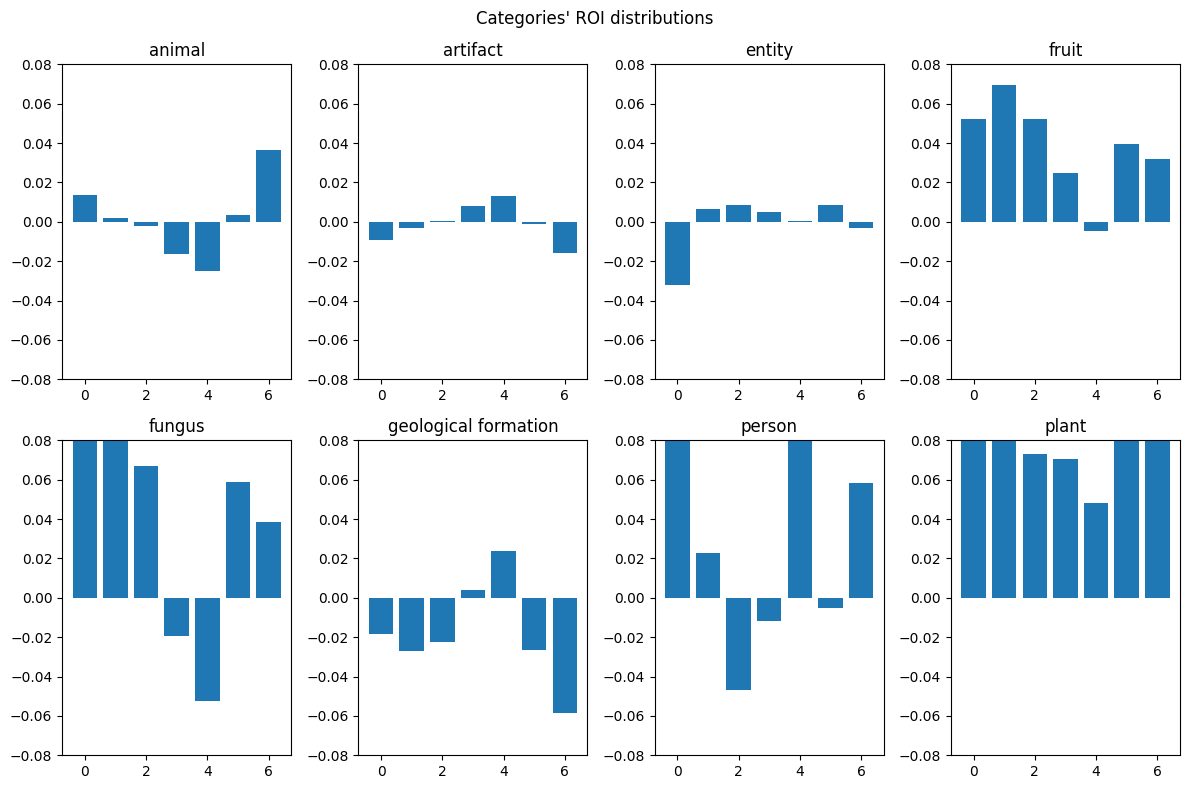

In [16]:
# Plot ROI distributions' means over all categories
# (Hardcoded to only work on category hierarchy 0 for now)

unique_labels = np.unique(labels[0, :])
# Lists to store values
total_roi_values = np.zeros((len(unique_labels), len(roi_names) - 1))
# (I didn't know how to get the sample count for each category?)
category_counts = [589, 812, 72, 77, 5, 192, 2, 1]

# Loop to go through each sample 
for i in range(len(labels[0])):
    # Loop to go through each unique label (category)
    for label in range(len(unique_labels)):
        # Assign computed ROI distribution to total ROI value list in correct index (hence the previous loop)
        if labels[0][i] == unique_labels[label]:
            total_roi_values[label] += compute_roi_bins(i)

# Loop to update total ROI value list to means
for label in range(len(total_roi_values)):
    total_roi_values[label] /= category_counts[label]

barplot_roi_distribution("Categories' ROI distributions", total_roi_values, unique_labels, ylim=[-0.08, 0.08], plot_rows=2, plot_cols=4)

## Pattern analysis

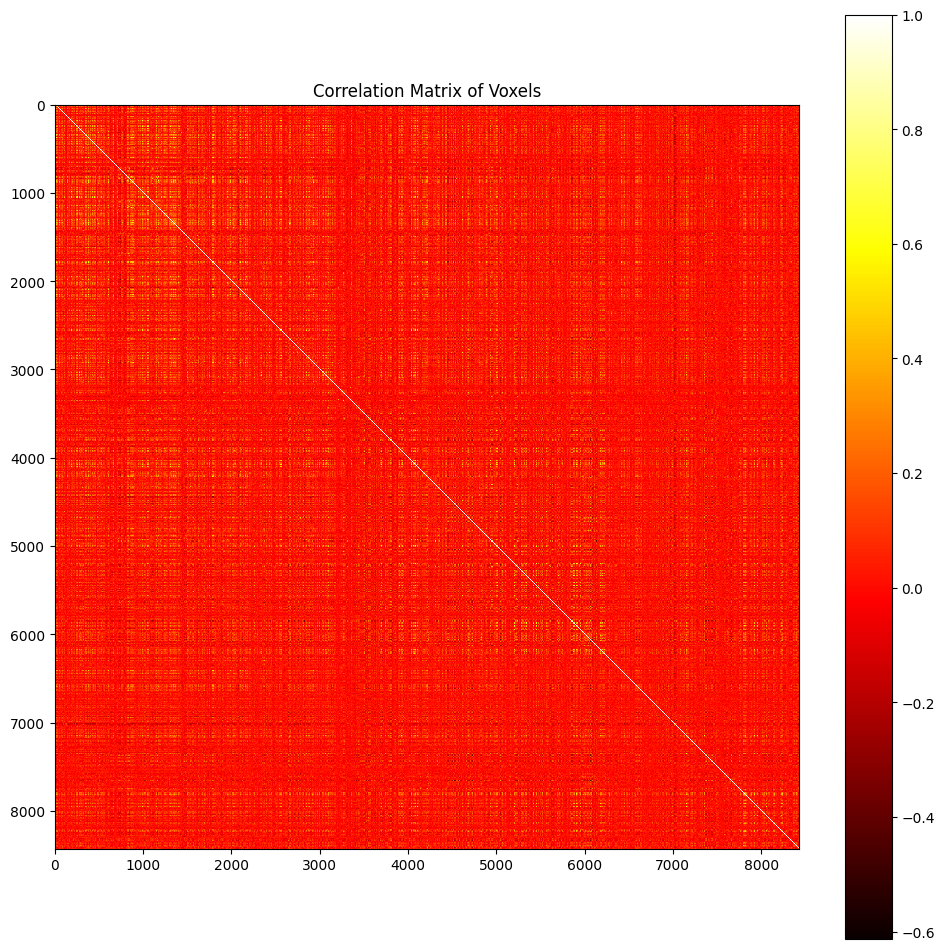

In [19]:
# Computing correlation
correlation_matrix = np.corrcoef(sorted_responses.T)  # Transpose to get voxels as features
#correlation_matrix = np.corrcoef(training_outputs.T)  # Transpose to get voxels as features

# Plotting
plt.figure(figsize=(12, 12))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.title("Correlation Matrix of Voxels")
plt.colorbar()
plt.show()

d:\Users\Simon\ITU\MSc\ADMAL\ADMAL-Project\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Users\Simon\ITU\MSc\ADMAL\ADMAL-Project\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
d:\Users\Simon\ITU\MSc\ADMAL\ADMAL-Project\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


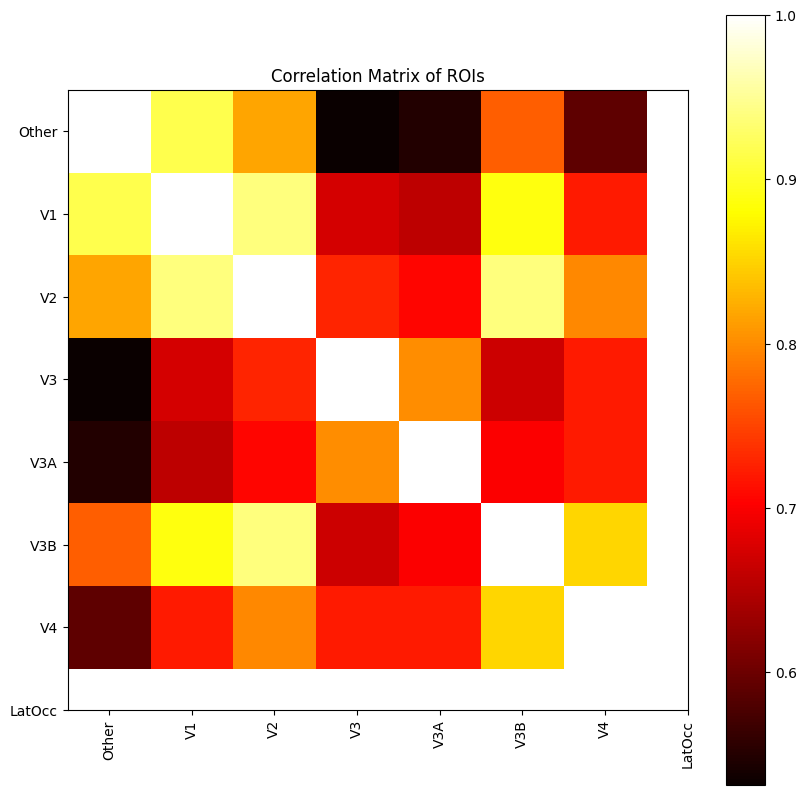

In [125]:
# Initialize a dictionary to hold the averaged responses for each ROI
roi_averaged_responses = {roi_name: [] for roi_name in roi_names if roi_name != 'Other'}

# Calculate the mean response for each ROI
for roi_name in roi_names:
    roi_idx = np.where(roi_names == roi_name)[0][0]
    roi_responses = training_outputs[:, roi == roi_idx]
    roi_averaged_responses[roi_name] = np.mean(roi_responses, axis=1)

# Convert the dictionary to a matrix
roi_response_matrix = np.array([roi_averaged_responses[roi_name] for roi_name in roi_names if roi_name != 'Other'])

# Compute the correlation matrix
roi_correlation_matrix = np.corrcoef(roi_response_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(roi_correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=np.arange(len(roi_names)), labels=roi_names, rotation=90)
plt.yticks(ticks=np.arange(len(roi_names)), labels=roi_names)
plt.title("Correlation Matrix of ROIs")
plt.show()


In [114]:
# Select ROI to investigate from 'V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'
roi_name = 'LatOcc'

# Identify unique categories
categories = np.unique(labels[0])  # Assuming row 3 has the final categories
print(categories)

# Find the index of the ROI name in the roi_names array
roi_idx = np.where(roi_names == roi_name)[0][0]  # Adjust roi_name as needed

# Prepare a dictionary to hold category-wise responses for the specific ROI
category_responses = {category: [] for category in categories}

# Populate the dictionary with responses filtered for the specific ROI
for i, label in enumerate(labels[0]):
    # Filter the responses for the specific ROI
    roi_specific_response = training_outputs[i][roi == roi_idx]
    category_responses[label].append(roi_specific_response)

# Average the responses for each category within the ROI
average_responses = {category: np.mean(np.array(responses), axis=0) for category, responses in category_responses.items()}

['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant']


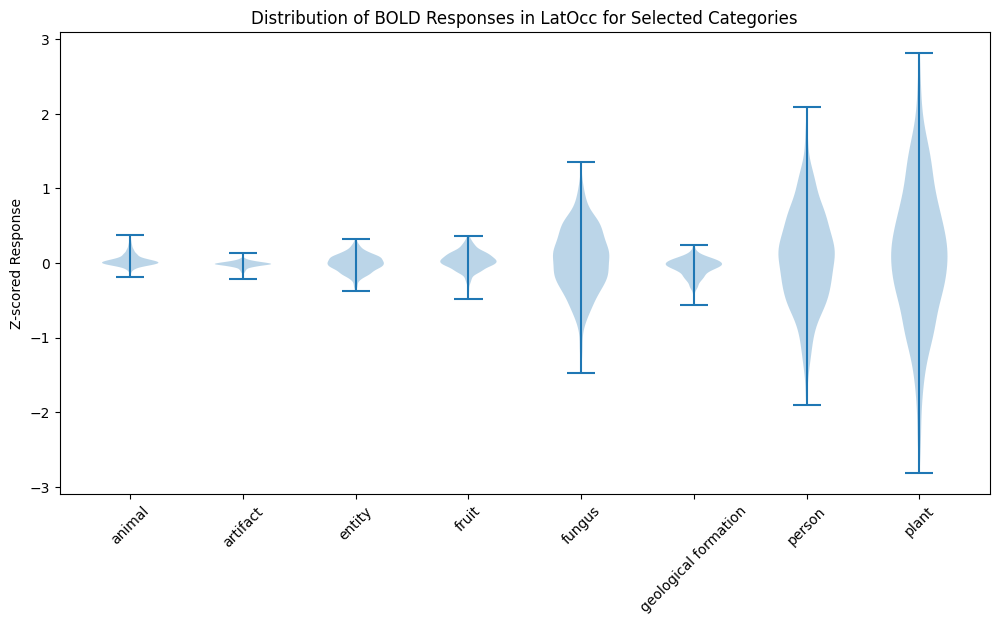

In [115]:
plt.figure(figsize=(12, 6))
data_to_plot = [average_responses[category] for category in categories]
plt.violinplot(data_to_plot)
plt.xticks(range(1, len(categories)+1), categories, rotation=45)
plt.title(f"Distribution of BOLD Responses in {roi_name} for Selected Categories")
plt.ylabel("Z-scored Response")
plt.show()


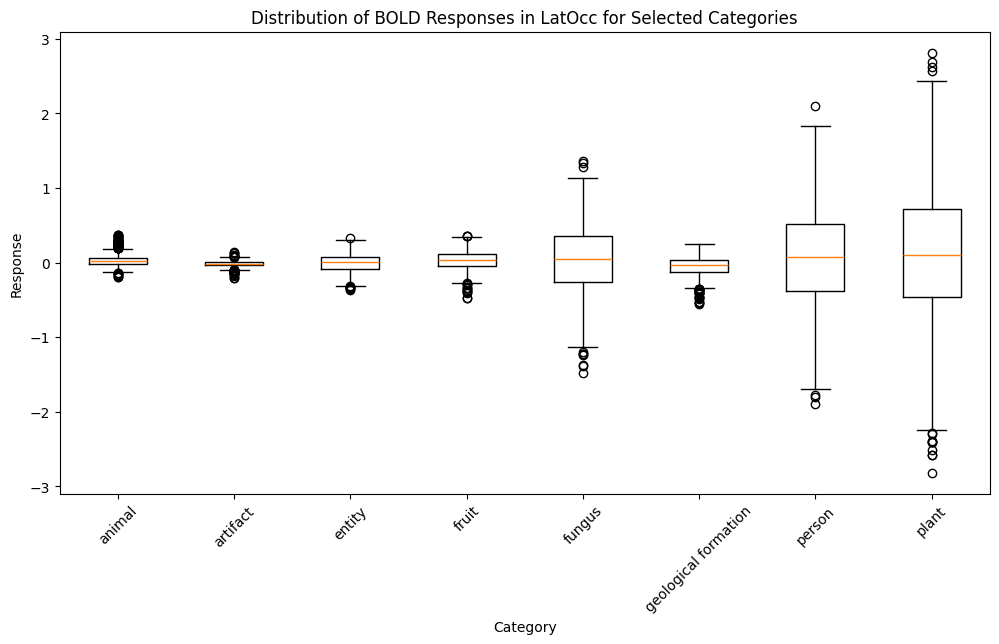

In [116]:
plt.figure(figsize=(12, 6))
data_to_plot = [response for category, response in average_responses.items() if category in categories]
plt.boxplot(data_to_plot, labels=categories)
plt.title(f"Distribution of BOLD Responses in {roi_name} for Selected Categories")
plt.xlabel("Category")
plt.ylabel("Response")
plt.xticks(rotation=45)
plt.show()

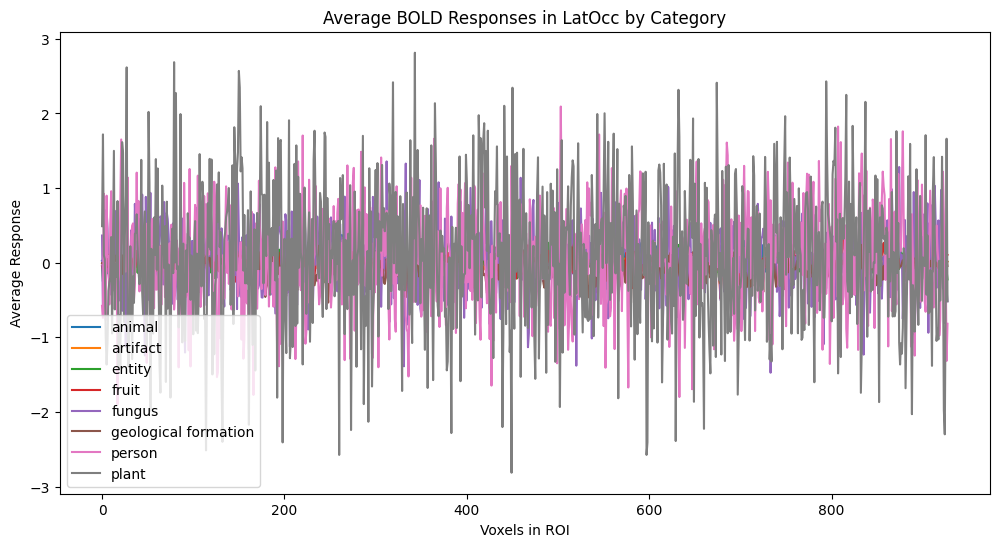

In [117]:
plt.figure(figsize=(12, 6))
x_values = range(len(next(iter(average_responses.values()))))  # Assuming all categories have the same number of voxels in the ROI
for category, response in average_responses.items():
    plt.plot(x_values, response, label=category)

plt.title(f"Average BOLD Responses in {roi_name} by Category")
plt.xlabel("Voxels in ROI")
plt.ylabel("Average Response")
plt.legend()
plt.show()
